# Workflow Step-by-Step

1. Import packages
2. Initialize variables
3. Add gates
4. Visualize the circuit
5. Simulate the experiment
6. Visualize the results

In [1]:
# Step 1: Import Packages

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np

#QuantumCircuit: instructions of quantum system,
    # holds all quantum operations
    
#AerSimulator: Aer high performance circuit simulator

#plot_histogram: creates histograms

In [2]:
# Step 2: Initialize variables

#Eg: initializing a circuit with 2 qubits in zeros state
    # with 2 classical bits set to zero

q = QuantumRegister(5) #create a five qubit circuit
c = ClassicalRegister(5)
qc = QuantumCircuit(q, c)

In [3]:
# Step 3: Add gates

qc.h(q[4])
qc.crz(np.pi/2, q[3] ,q[4])
qc.crz(np.pi/4, q[2] ,q[4])
qc.crz(np.pi/8, q[1] ,q[4])
qc.crz(np.pi/16, q[0] ,q[4])

qc.barrier()

qc.h(q[3])
qc.crz(np.pi/2, q[2] ,q[3])
qc.crz(np.pi/4, q[1] ,q[3])
qc.crz(np.pi/8, q[0] ,q[3])

qc.barrier()

qc.h(q[2])
qc.crz(np.pi/2, q[1] ,q[2])
qc.crz(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[2])
qc.crz(np.pi/2, q[1] ,q[2])
qc.crz(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[1])
qc.crz(np.pi/2, q[0] ,q[1])

qc.barrier()

qc.h(q[0])

qc.barrier()

qc.swap(q[0] ,q[4])
qc.swap(q[1] ,q[3])

qc.measure_all()

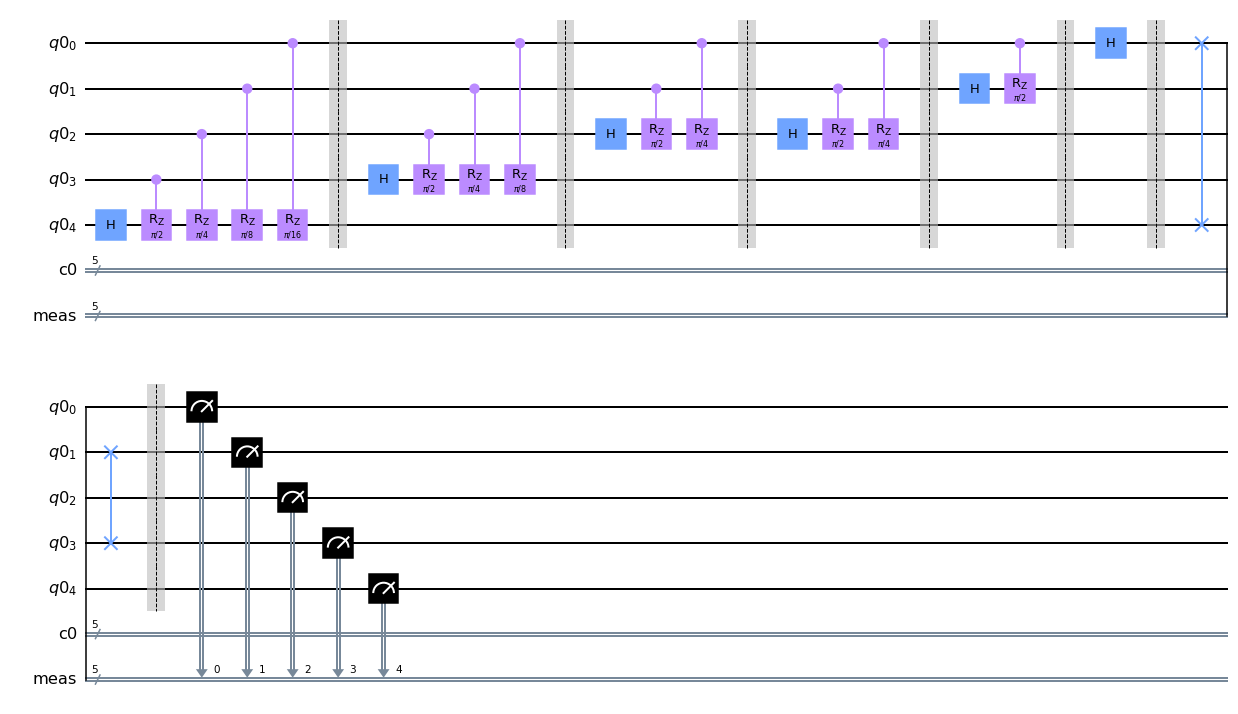

In [4]:
# Step 4: visualize the circuit

qc.draw('mpl') #stylized
#qc.draw() #not-stylized

In [5]:
# Step 5: Simulate the Experiment

# uses the `AerSimulator`
# Each run of the circuit will yield bit string '00' or '11'

simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

#Number of times circuit is run = shots
job = simulator.run(compiled_circuit, shots=4000)

#Create a `result` object to access the counts
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'01011 00000': 253, '00010 00000': 254, '00001 00000': 216, '00000 00000': 268, '10000 00000': 267, '01001 00000': 290, '10011 00000': 241, '01000 00000': 225, '11011 00000': 254, '11010 00000': 251, '10001 00000': 244, '11001 00000': 269, '11000 00000': 255, '01010 00000': 236, '00011 00000': 239, '10010 00000': 238}


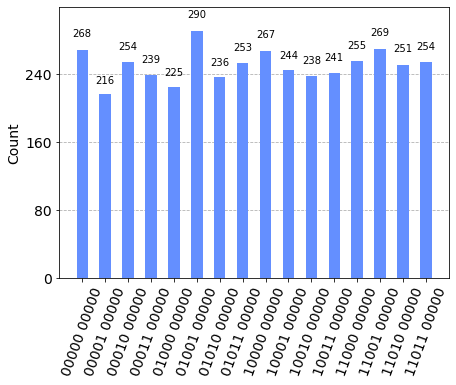

In [6]:
# Step 6: visualize the results

plot_histogram(counts)

In [7]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

#plot_state_city(qc)

# Parallelization with DASK

Dask is an open source Python library for parallel computing. The dask.distributed module for distributed computing facilitates the scheduling of tasks dynamically across multiple machines. Users need only submit their tasks to a DASK cluster, and the library will distribute them across a specified number of nodes and collect the results automatically. This functionality made it an excellent choice for enabling parallelization of circuit executions for Aer.

In [7]:
from dask.distributed import Client

In [8]:
#client = Client(threads_per_worker=4, n_workers=1) # start distributed scheduler locally.
client = Client()

client


Client Scheduler: tcp://127.0.0.1:50605 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 15.75 GiB


In [9]:
print(len(client.scheduler_info()['workers']))
#client.close()

4


In [16]:
#import dask.array as da
#x = da.random.random((1000, 1000, 10), chunks=(100, 100, 5))
#y = da.random.random((1000, 1000, 10), chunks=(100, 100, 5))
#z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1, 2))
#z.compute()

#client.close()

### Testing Dask with Qiskit

In [18]:
from qiskit import execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import QuantumVolume
from dask.distributed import Client
from qiskit.visualization import plot_histogram
import time



# Prepare some circuits ========================

q = QuantumRegister(5) #create a five qubit circuit
c = ClassicalRegister(5)
qc = QuantumCircuit(q, c)

qc.h(q[4])
qc.crz(np.pi/2, q[3] ,q[4])
qc.crz(np.pi/4, q[2] ,q[4])
qc.crz(np.pi/8, q[1] ,q[4])
qc.crz(np.pi/16, q[0] ,q[4])

qc.barrier()

qc.h(q[3])
qc.crz(np.pi/2, q[2] ,q[3])
qc.crz(np.pi/4, q[1] ,q[3])
qc.crz(np.pi/8, q[0] ,q[3])

qc.barrier()

qc.h(q[2])
qc.crz(np.pi/2, q[1] ,q[2])
qc.crz(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[2])
qc.crz(np.pi/2, q[1] ,q[2])
qc.crz(np.pi/4, q[0] ,q[2])

qc.barrier()

qc.h(q[1])
qc.crz(np.pi/2, q[0] ,q[1])

qc.barrier()

qc.h(q[0])

qc.barrier()

qc.swap(q[0] ,q[4])
qc.swap(q[1] ,q[3])

qc.measure_all()
#========================================


# Initialise DASK client
my_dask_client = client

# Initialise your Aer simulator
backend = AerSimulator()

SHOTS = 1e6
# Set the client as a custom executor for your backend
backend.set_options(executor=my_dask_client, max_parallel_threads=12, max_parallel_experiments=1000)

# Run your circuits
#result = backend.run(qc).result()
# Start time


compiled_circuit = transpile(qc, backend)

time1 = time.time()

result = backend.run(compiled_circuit, shots=SHOTS).result()


time1final = time.time() - time1

#=========================

print(f'Time taken using DASK, with {len(client.scheduler_info()["workers"])} workers, {client.nthreads}: {time1final}')

counts = result.get_counts(qc)
#print(counts)


Time taken using DASK, with 4 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:50605' processes=4 threads=12, memory=15.75 GiB>>: 2.0109667778015137


In [63]:

#print(f'Time taken using DASK, with {len(client.scheduler_info()["workers"])} workers, {client.nthreads}: {time1final}')

#counts = result.get_counts(qc)
print(counts)

{'11000 00000': 62668, '01011 00000': 62254, '01010 00000': 62999, '10011 00000': 62332, '00011 00000': 62620, '01001 00000': 62528, '11011 00000': 62237, '10001 00000': 62378, '10000 00000': 62356, '00000 00000': 62470, '01000 00000': 61957, '10010 00000': 62765, '11010 00000': 62850, '00010 00000': 62541, '00001 00000': 62600, '11001 00000': 62445}


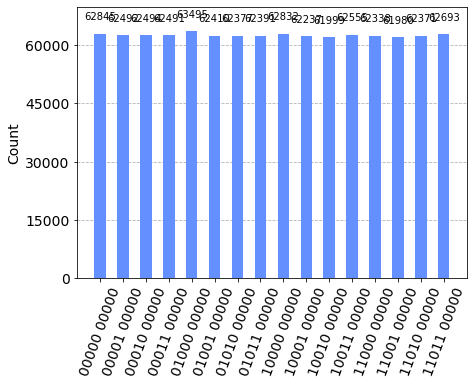

In [23]:
plot_histogram(counts)

In [15]:
# Close the DASK cluster connection once finished
my_dask_client.close()

SHOTS = 4000

Time taken using DASK, with 1 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:55965' processes=1 threads=4, memory=15.75 GiB>>: 0.1480410099029541

Time taken using DASK, with 4 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56063' processes=4 threads=12, memory=15.75 GiB>>: 3.298123359680176

SHOTS = 10,000

Time taken using DASK, with 1 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56141' processes=1 threads=4, memory=15.75 GiB>>: 0.1640305519104004

Time taken using DASK, with 4 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56063' processes=4 threads=12, memory=15.75 GiB>>: 0.46541762351989746

SHOTS = 100,000

Time taken using DASK, with 1 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56141' processes=1 threads=4, memory=15.75 GiB>>: 0.5527238845825195

Time taken using DASK, with 4 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56063' processes=4 threads=12, memory=15.75 GiB>>: 0.6290633678436279

SHOTS = 1,000,000

Time taken using DASK, with 1 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56141' processes=1 threads=4, memory=15.75 GiB>>: 4.047971487045288


Time taken using DASK, with 4 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56063' processes=4 threads=12, memory=15.75 GiB>>: 4.16028904914856

SHOTS = 10,000,000

Time taken using DASK, with 1 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56141' processes=1 threads=4, memory=15.75 GiB>>: 40.73687291145325

Time taken using DASK, with 4 workers, <bound method Client.nthreads of <Client: 'tcp://127.0.0.1:56063' processes=4 threads=12, memory=15.75 GiB>>: 37.66500544548035

===============================

Seems that no parallelization is occuring

===============================

### Why no parallelization is being seen:

This was because `max_job_size` was set to 1, meaning cluster was running 1 circuit per job. 

Even if set to higher numbers, we are only ever running `qc` once, just changing the shots at which we are evaluating it. 

So, `DASK` is only for multiple circuits at once via a `circ_list` run in `result = backend.run(compiled_circuit, shots=1e6).result()` instead of `compiled circuit`. 


## Testing

In [12]:
from qiskit import execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import QuantumVolume
from dask.distributed import Client

# Prepare some circuits
circ_list = []
for i in range(10):
  circ = transpile(QuantumVolume(num_qubits=10, depth=1), basis_gates=['u','cx'])
  circ.measure_all()
  circ_list.append(circ)

qc_list = []
for i in range(4):
  circ = qc
  circ.measure_all()
  qc_list.append(circ)

#qc_list[3].draw()



# Initialise DASK client
my_dask_client = client

# Initialise your Aer simulator
backend = AerSimulator()

SHOTS = 1e4
# Set the client as a custom executor for your backend
backend.set_options(executor=my_dask_client, max_job_size = 1)  #max_parallel_threads=1, max_parallel_experiments=1)

# Run your circuits
#result = backend.run(qc).result()
# Start time


compiled_circuit = transpile(qc_list, backend)

time1 = time.time()

#result = backend.run(compiled_circuit, shots=SHOTS).result()
result = backend.run(circ_list).result()

time1final = time.time() - time1

#=========================

print(f'Time taken using DASK, with {len(client.scheduler_info()["workers"])} workers, {client.nthreads}: {time1final}')

counts = result.get_counts(qc)
#print(counts)

TypeError: cannot pickle '_global_parameters' object

# ==============================================

# QFT Implementation from Qiskit

https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

In [271]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
#from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [272]:
# Allows creation of ladder circuits

def qft_rotations_ladder(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

In [273]:
# Eg: Ladder circuit for n=4
n=4
qc = QuantumCircuit(n)
qft_rotations_ladder(qc,n)
qc.draw()

q_0: ──────■─────────────────────────
           │                         
q_1: ──────┼────────■────────────────
           │        │                
q_2: ──────┼────────┼────────■───────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) 
q_3: ┤ H ├─■────────■────────■───────
     └───┘

In [274]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [275]:
# Eg: QFT circuit for n=4
n=3
qc = QuantumCircuit(n)
qft_rotations(qc,n)
qc.draw()

┌───┐
q_0: ──────■──────────────────────■───────┤ H ├
           │                ┌───┐ │P(π/2) └───┘
q_1: ──────┼────────■───────┤ H ├─■────────────
     ┌───┐ │P(π/4)  │P(π/2) └───┘              
q_2: ┤ H ├─■────────■──────────────────────────
     └───┘

In [276]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [277]:
# Let's see how it looks:
n=3
qc = QuantumCircuit(n)
qft(qc,n)
qc.draw()

┌───┐   
q_0: ──────■──────────────────────■───────┤ H ├─X─
           │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

We now want to demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis. We can see the number 5 in binary is 101:


In [278]:
bin(5)

'0b101'

In [279]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

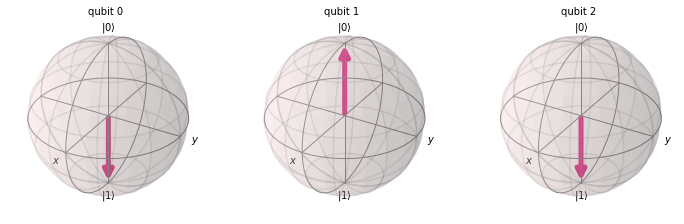

In [280]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [281]:
qft(qc,3)
qc.draw()

┌───┐                                     ┌───┐   
q_0: ┤ X ├──────■──────────────────────■───────┤ H ├─X─
     └───┘      │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ───────────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ X ├┤ H ├─■────────■───────────────────────────X─
     └───┘└───┘

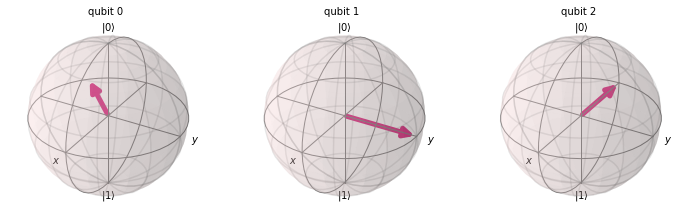

In [282]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

In [283]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

Now let's put our qubits in the state $|\tilde{5}\rangle$:

In [284]:
nqubits = 3
number = 4
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐ ┌──────┐
q_0: ┤ H ├─┤ P(π) ├
     ├───┤┌┴──────┤
q_1: ┤ H ├┤ P(2π) ├
     ├───┤├───────┤
q_2: ┤ H ├┤ P(4π) ├
     └───┘└───────┘

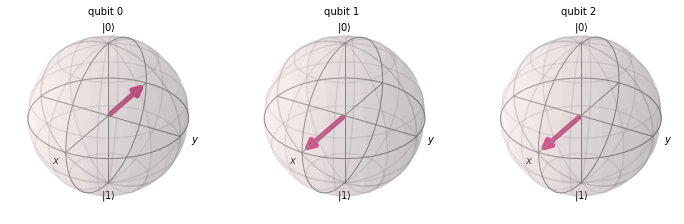

In [285]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Applying IQFT:

In [286]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐ ┌──────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├─┤ U(0,0,π) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤┌┴──────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,2π) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤├───────────┤ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├┤ U(0,0,4π) ├─X──────────────────────■─────────■────────»
        └─────────┘└───────────┘                                           »
meas: 3/═══════════════════════════════════════════════════════════════════»
                                                                           »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

In [287]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

#Number of times circuit is run = shots
job = simulator.run(compiled_circuit, shots=1000)

#Create a `result` object to access the counts
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'100': 1000}


# Aer Simulator Options

In [305]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

In [306]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [307]:
simulator = Aer.get_backend('aer_simulator')

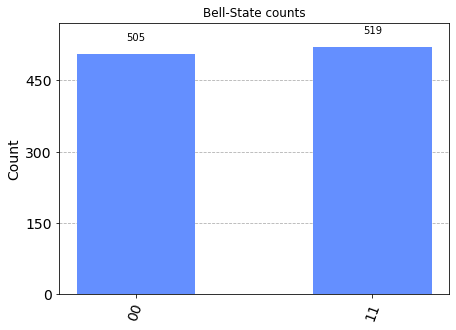

In [312]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [315]:
# Run and get memory
result = simulator.run(circ, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['11', '00', '11', '00', '11', '11', '00', '00', '00', '00']


In [316]:
# Increase shots to reduce sampling variance
shots = 100

# Stabilizer simulation method
sim_stabilizer = Aer.get_backend('aer_simulator_stabilizer')
job_stabilizer = sim_stabilizer.run(circ, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts(0)

# Statevector simulation method
sim_statevector = Aer.get_backend('aer_simulator_statevector')
job_statevector = sim_statevector.run(circ, shots=shots)
counts_statevector = job_statevector.result().get_counts(0)

# Density Matrix simulation method
sim_density = Aer.get_backend('aer_simulator_density_matrix')
job_density = sim_density.run(circ, shots=shots)
counts_density = job_density.result().get_counts(0)

# Matrix Product State simulation method
sim_mps = Aer.get_backend('aer_simulator_matrix_product_state')
job_mps = sim_mps.run(circ, shots=shots)
counts_mps = job_mps.result().get_counts(0)

plot_histogram([counts_stabilizer, counts_statevector, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=['stabilizer', 'statevector',
                       'density_matrix', 'matrix_product_state'])

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-17861 contains invalid instructions {"gates": {u2}} for "stabilizer" method.Circuit circuit-17861 contains invalid parameters  for "stabilizer" method.


QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-17861 contains invalid instructions {"gates": {u2}} for "stabilizer" method.Circuit circuit-17861 contains invalid parameters  for "stabilizer" method. ,  ERROR: Circuit circuit-17861 contains invalid instructions {"gates": {u2}} for "stabilizer" method.Circuit circuit-17861 contains invalid parameters  for "stabilizer" method.'

In [318]:
from qiskit_aer import AerError

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)

# Matrix Product State Simulation

The AerSimulator has several simulation methods including statevector, stabilizer, extended_stabilizer and matrix_product_state. Each of these determines the internal representation of the quantum circuit and the algorithms used to process the quantum operations. They each have advantages and disadvantages, and choosing the best method is a matter of investigation. In this tutorial, we focus on the matrix product state simulation method.

In [302]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Construct quantum circuit
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0,1], [0,1])

# Select the AerSimulator from the Aer provider
simulator = AerSimulator(method='matrix_product_state')

# Run and get counts, using the matrix_product_state method
tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(0)
counts

{'00': 486, '11': 538}

In [303]:
# Can see the internal state vector of the circuit using `.save_statevector`
# Can see the full internal MPS structure using `.save_matrix_product_state`

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)

# Define a snapshot that shows the current state vector
circ.save_statevector(label='my_sv')
circ.save_matrix_product_state(label='my_mps')
circ.measure([0,1], [0,1])

# Execute and get saved data
tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
data = result.data(0)

#print the result data
data

{'counts': {'0x3': 505, '0x0': 519},
 'my_sv': Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
              0.70710678+0.j],
             dims=(2, 2)),
 'my_mps': ([(array([[1.-0.j, 0.-0.j]]), array([[0.-0.j, 1.-0.j]])),
   (array([[1.-0.j],
           [0.-0.j]]),
    array([[0.-0.j],
           [1.-0.j]]))],
  [array([0.70710678, 0.70710678])])}

Running circuits using the matrix product state simulation method can be fast, relative to other methods. However, if we generate the state vector during the execution, then the conversion to state vector is, of course, exponential in memory and time, and therefore we don’t benefit from using this method. We can benefit if we only do operations that don’t require printing the full state vector. For example, if we run a circuit and then take measurement. The circuit below has 200 qubits. We create an EPR state involving all these qubits. Although this state is highly entangled, it is handled well by the matrix product state method, because there are effectively only two states.

We can handle more qubits than this, but execution may take a few minutes. Try running a similar circuit with 500 qubits! Or maybe even 1000 (you can get a cup of coffee while waiting).

In [304]:
num_qubits = 50
circ = QuantumCircuit(num_qubits, num_qubits)

# Create EPR state
circ.h(0)
for i in range (0, num_qubits-1):
    circ.cx(i, i+1)

# Measure
circ.measure(range(num_qubits), range(num_qubits))

tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
print("Time taken: {} sec".format(result.time_taken))
result.get_counts()

Time taken: 0.2199692726135254 sec


{'00000000000000000000000000000000000000000000000000': 510,
 '11111111111111111111111111111111111111111111111111': 514}

In [35]:
from qiskit import execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import QuantumVolume
from dask.distributed import Client
import time

# Prepare some circuits
circ_list = []
for i in range(100):
  circ = transpile(QuantumVolume(num_qubits=12, depth=2), basis_gates=['u','cx'])
  circ.measure_all()
  circ_list.append(circ)
  
# Initialise DASK client
my_dask_client = client

# Initialise your Aer simulator
backend = AerSimulator()

# Set the client as a custom executor for your backend
backend.set_options(executor=my_dask_client, max_job_size=1)

time1 = time.time()

# Run your circuits
result = backend.run(circ_list).result()

timefinal = time.time() - time1
print(timefinal)

# Close the DASK cluster connection once finished
#my_dask_client.close()

0.7414917945861816


0.7403004169464111
